In [7]:
import io
from utils import XML
import matplotlib.pyplot as plt


In [2]:
# get the OIS curves (already calibrated) from the markit website
curveURL = "http://www.markit.com/news/InterestRates_USD_20170105.zip"
USD_ratecurve = XML.ParseXMLRateCurve(curveURL)


,source,tenor,maturity,parrate,YTM
0,deposit,1M,2017-02-10,0.007656,0.083333
1,deposit,2M,2017-03-10,0.008244,0.166667
2,deposit,3M,2017-04-10,0.010093,0.250000
3,deposit,6M,2017-07-10,0.013210,0.500000
4,deposit,1Y,2018-01-10,0.016890,1.000000
5,swaps,2Y,2019-01-10,0.014320,2.000000
6,swaps,3Y,2020-01-10,0.016215,3.000000
7,swaps,4Y,2021-01-10,0.017655,4.000000
8,swaps,5Y,2022-01-10,0.018850,5.000000
9,swaps,6Y,2023-01-10,0.019810,6.000000


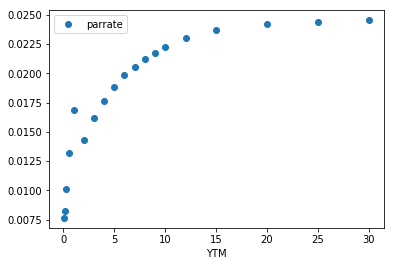

In [11]:
# On graph la courbe (non calibrée)
USD_ratecurve.plot(x='YTM', y='parrate', style='o')
